# Importing Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

In [2]:
import nltk
import re
import string
from string import digits
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from matplotlib.pyplot import figure


In [3]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer , TfidfVectorizer

In [4]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


In [43]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# About the Dataset and Project Objective

The data has been taken from UCI repository and is regarding the use of a drug type for some medical condition alongwith the reviews and ratings from the user. The data was collected from various pharmaceutical company websites. There are 2 files which had been compiled for analysis as train and test data. The data percentages of train and test was set to 75% and 25% respectively.

The objective of the project is whether we can predict the rating a user is likely going to give depending on the review submitted. This is essentially a classification problem which would be adressed by using unsupervised machine learning approach. A comparison would also be done against some machine learning models to access the effectiveness of the unsupervised model vs supervised model. The target variable is rating with the possible ratings between '1' and '10'.

The reason for taking this project is to practically deploy whatever has been learnt in this course to augment the concepts and approaches to different kind of problems. Additionally, augmenting NLP would also be great in identifying the sentiment of a review which in turn would determine the final rating given by a user/patient/carer. 

**Citation** Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning.

# Sequence of Work

The project will be carried out in the following sequence:

1. Data Import
2. Data Overview
3. Data Cleaning
4. EDA
5. Models Design
6. Models Testing
7. Model Optimization
8. Results and Analysis
9. Conclusion

# 1. Importing Data

In [87]:
df_train=pd.read_csv('drugsComTrain_raw.tsv',sep='\t')
df_test=pd.read_csv('drugsComTest_raw.tsv',sep='\t')

# 2. Data Overview

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   53766 non-null  int64  
 1   drugName     53766 non-null  object 
 2   condition    53471 non-null  object 
 3   review       53766 non-null  object 
 4   rating       53766 non-null  float64
 5   date         53766 non-null  object 
 6   usefulCount  53766 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


**1.** The **training dataset has 161297 observations against 7 features** whereas the **test dataset has 53766 observations against the same 7 features**.

**2.** The size of **training is 8.6mb** and **test 2.9mb**.

**3.** The datset contains 4 object types, 2int types and 1 float i.e. the ratings.

**Feature Info**

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful

The first feature 'Unnamed:0' is simply the id the person giving the review.

# 3. Data Cleaning

Since, our objective for the project is to be able to predict the ratings based on the user review, we will be getting rid of the remaining columns.


In [88]:
df_train.drop(['Unnamed: 0', 'drugName','condition','date','usefulCount'], inplace = True,axis = 1)
df_test.drop(['Unnamed: 0', 'drugName','condition','date','usefulCount'], inplace = True , axis = 1)

**Checking for NA values**

In [8]:
df_train.isna().sum()

review    0
rating    0
dtype: int64

In [9]:
df_test.isna().sum()

review    0
rating    0
dtype: int64

The number of observations remains the same, however, after getting rid of the redundant features as per our project objective, we have only 2 columns remaining namely 'review' and 'rating'.

## Processing Text

There are two main steps involved in the processing of text, i.e. removing unnecessary alphanumerics, puncuations, numbers etc. and then vectorizing the sentences into words for further study and modelling.

We undertook the following steps in the model training:
1. Word Tokenization
2. Removal of Alpha numerics
3. Removal of Punctuations
4. Removal of Stop Words
5. Stemming the words
6. Lematizing the words
7. rejoining the words to return the modified senctence/text

### Text Cleaning (review column)

In [7]:
df_train['review'] = df_train['review'].astype(str)

In [8]:
stop = set(nltk.corpus.stopwords.words('english'))
stop_words = stop.union({'said','mr','known','ll','ms','ve', 'you', 'your', 'yet' , 'yes',
                             'yours',"ha", "thi", "now", "onli", "im", "becaus", "wa", "will",
                              "even", "go", "realli", "didnt", "abl",
                        'year'}) ###IMPORTANT######################################################


def cleaning(x):
    
    # converting to words
    tokens = word_tokenize(x)
    
    # convert to lower case
    words = [w.lower() for w in tokens]
    
    # removing alphanumerics
    words = [word for word in words if word.isalpha()]
    
    # removing punctuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]    
        
    # removing stopwords after modification
    words_mod = [w for w in stripped if not w in stop_words]
    
    # word stemming
    stemmer = PorterStemmer()
#     stemmed_words = " ".join([stemmer.stem(w) for w in words_mod])
    stemmed_words = [stemmer.stem(w) for w in words_mod]
    
    # word lemmatization
    lemmatizer = WordNetLemmatizer()
    sentence = " ".join([lemmatizer.lemmatize(w) for w in stemmed_words]) 
    
    sen = " ".join(sentence.split())
    
#     sentence = " ".join(words)
    
    return (sen)

In [9]:
train_text = df_train.review.apply(lambda x: cleaning(x))

In [10]:
vector = TfidfVectorizer( min_df = 50, ngram_range = (1,1),  stop_words='english')
word_vec = vector.fit_transform(train_text)

In [11]:
word_df = pd.DataFrame([vector.vocabulary_]).T
word_df.columns = ['count']
word_df.sort_values(by = 'count' , inplace = True ,ascending=False)

Text(0.5, 1.0, 'N-gram = 1')

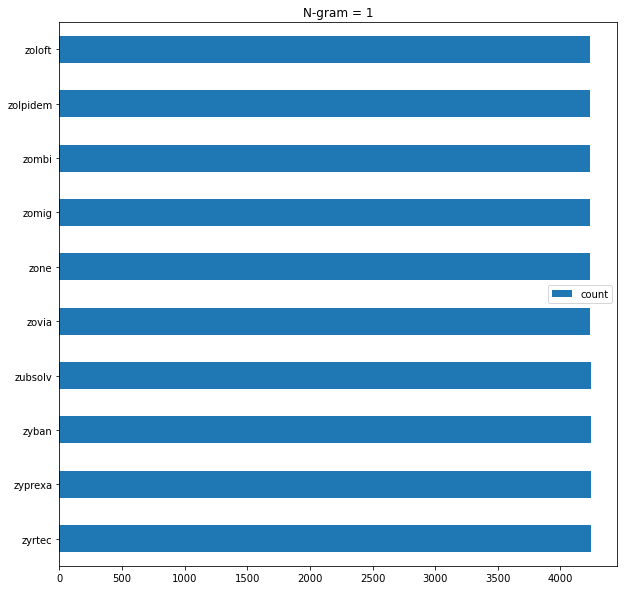

In [12]:
word_df.head(10).plot(kind = 'barh', figsize = (10,10))
plt.title('N-gram = 1')

Text(0.5, 1.0, 'N-gram = 2')

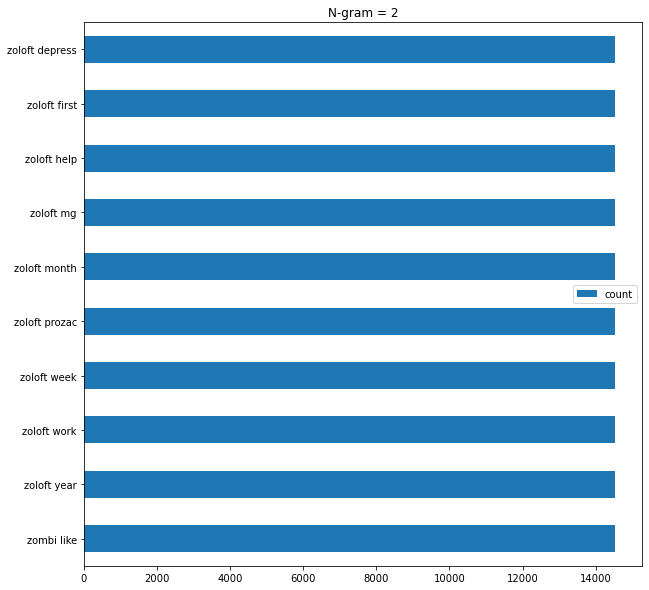

In [13]:
vector = TfidfVectorizer( min_df = 50, ngram_range = (2,2))
word_vec = vector.fit_transform(train_text)

word_df = pd.DataFrame([vector.vocabulary_]).T
word_df.columns = ['count']
word_df.sort_values(by = 'count' , inplace = True ,ascending=False)

word_df.head(10).plot(kind = 'barh', figsize = (10,10))
plt.title('N-gram = 2')

Text(0.5, 1.0, 'N-gram = 3')

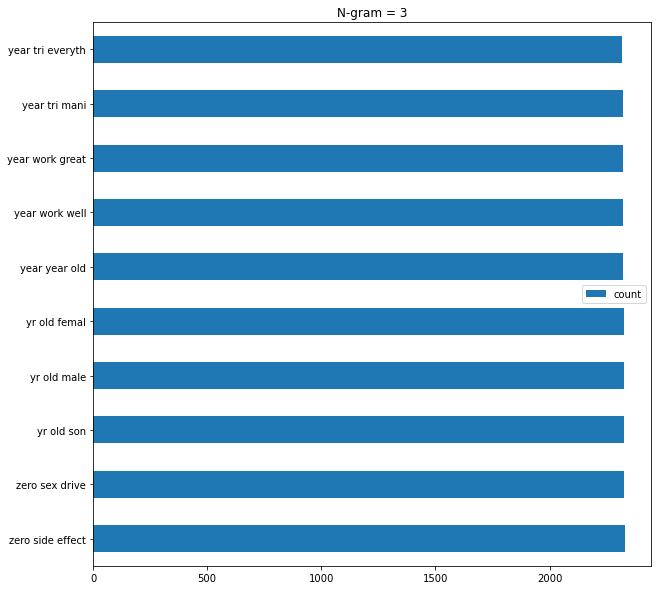

In [14]:
vector = TfidfVectorizer( min_df = 50, ngram_range = (3,3))
word_vec = vector.fit_transform(train_text)

word_df = pd.DataFrame([vector.vocabulary_]).T
word_df.columns = ['count']
word_df.sort_values(by = 'count' , inplace = True ,ascending=False)

word_df.head(10).plot(kind = 'barh', figsize = (10,10))
plt.title('N-gram = 3')

We can see from the graphs above that the name of the medicine is most occuring in the data when the min occurence is set a 50 whereas the time and effect are mostly displayed when we are refering to the ngrams set to 3.

# 4. EDA

In [15]:
df_train.describe()

,rating
count,161297.000000
mean,6.994377
std,3.272329
min,1.000000
25%,5.000000
50%,8.000000
75%,10.000000
max,10.000000


<AxesSubplot:ylabel='rating'>

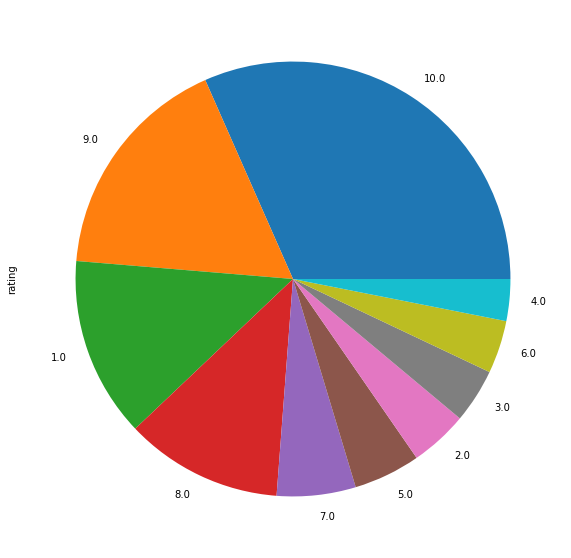

In [16]:
df_train.rating.value_counts().plot.pie(figsize = (10,10))

In [17]:
df_1 = df_train[df_train['rating'] == 1]
df_2 = df_train[df_train['rating'] == 2]
df_3 = df_train[df_train['rating'] == 3]
df_4 = df_train[df_train['rating'] == 4]
df_5 = df_train[df_train['rating'] == 5]
df_6 = df_train[df_train['rating'] == 6]
df_7 = df_train[df_train['rating'] == 7]
df_8 = df_train[df_train['rating'] == 8]
df_9 = df_train[df_train['rating'] == 9]
df_10 = df_train[df_train['rating'] == 10]

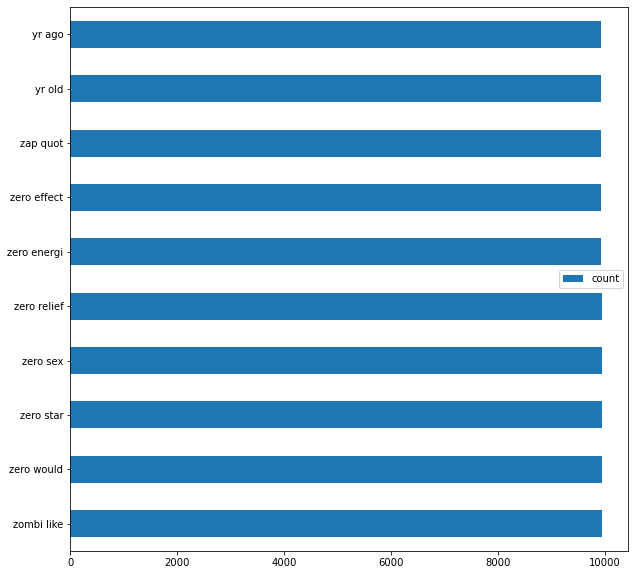

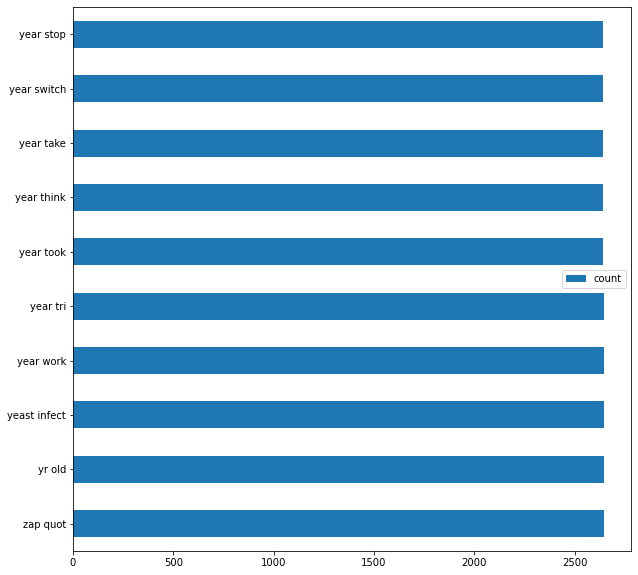

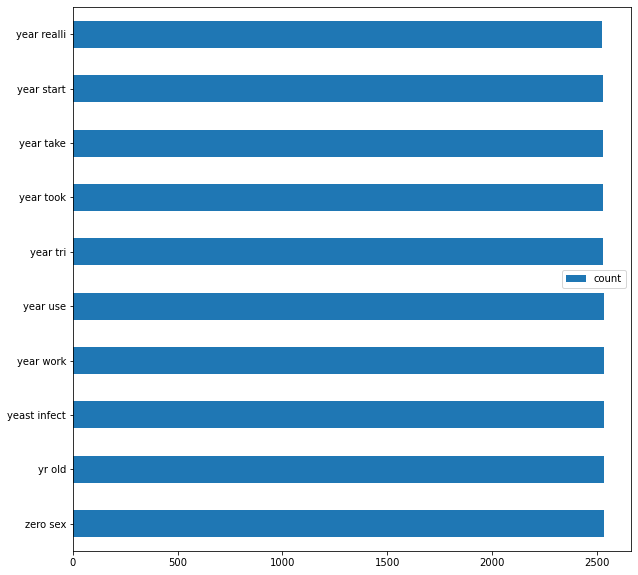

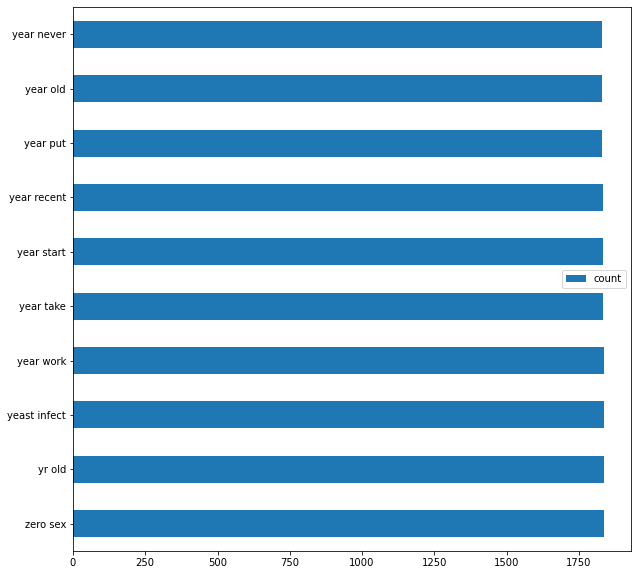

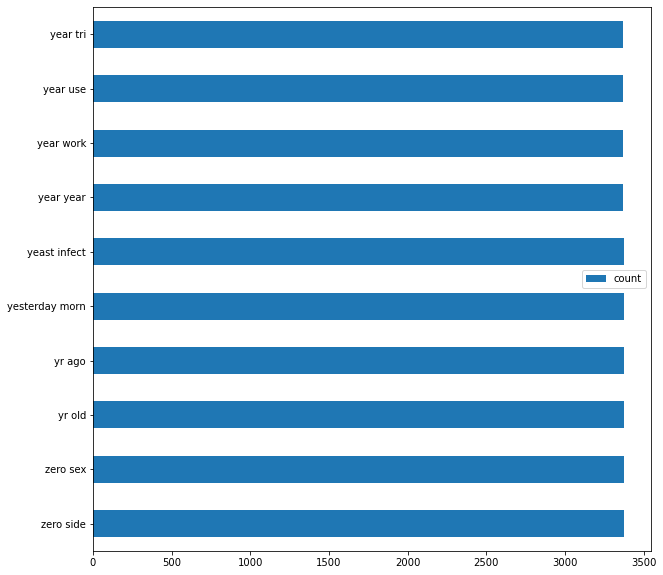

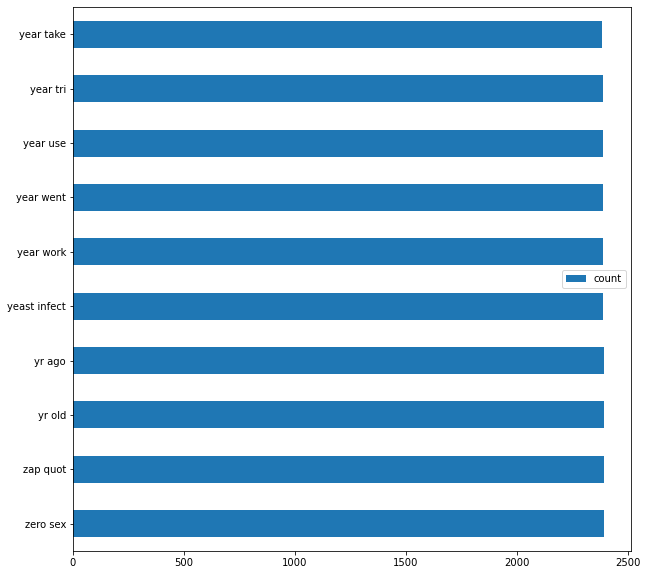

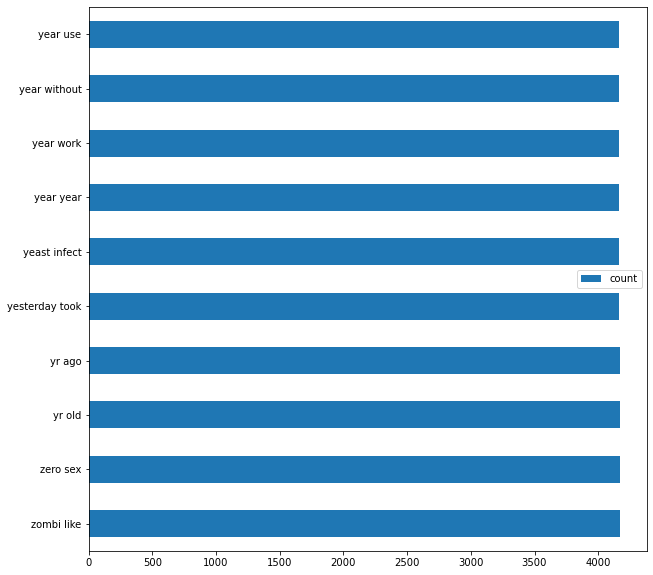

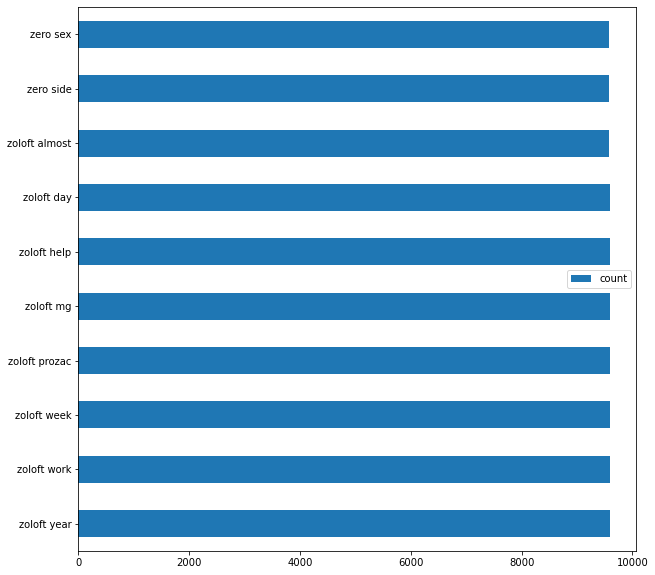

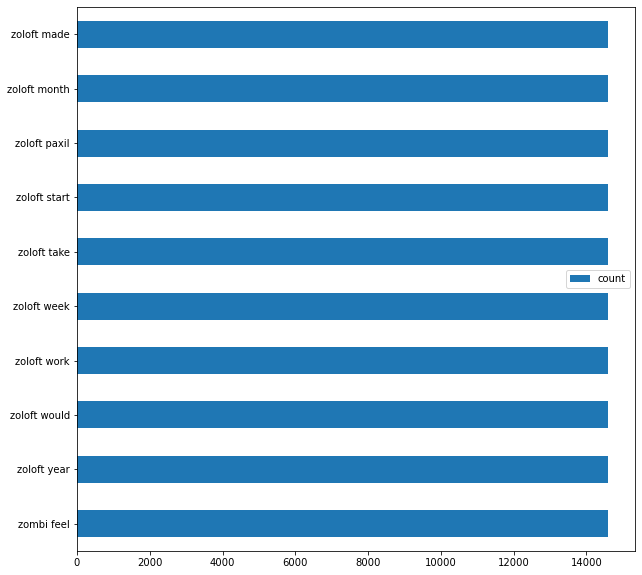

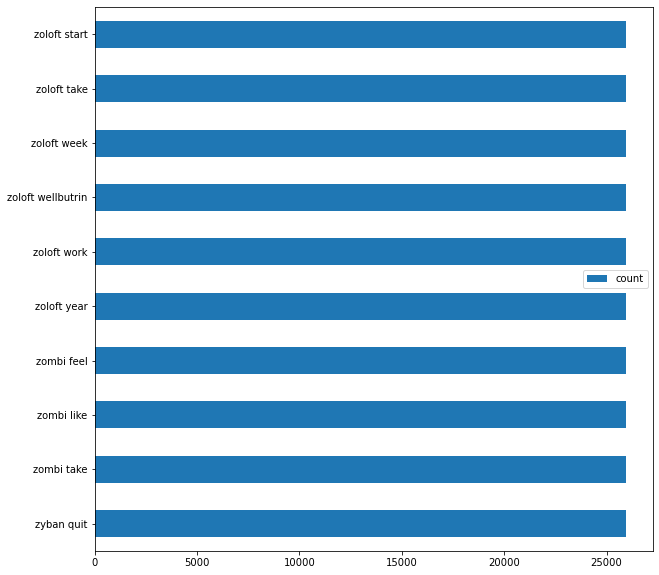

In [18]:
data= [df_1, df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10]
vector = TfidfVectorizer(min_df = 10 , ngram_range = (2,2))

for i in data:
    clean_data = i.review.apply(lambda x: cleaning(x))
    word_vec = vector.fit_transform(clean_data)

    word_df = pd.DataFrame([vector.vocabulary_]).T
    word_df.columns = ['count']
    word_df.sort_values(by = 'count' , inplace = True ,ascending=False)

    word_df.head(10).plot(kind = 'barh', figsize = (10,10))
#     plt.title(i)
    plt.show()

Here, we can take two things, firstly the ratings are not divided equally and a vast majority is skewed towards the higher side i.e. rating '9' and '10'. Secondly, the words among the various ratings seem to be quite similar. Due to this, our model accuracy will be compromised. Hence, it would be prudent to modify the ratings. **We will set the ratings into 3 categories, if rating is less than '5', we'll set it to '0', if it is within 5 to 8, we'll set it to '1' and higher than '8' to 2.**

'0' implies 'Bad'.

'1' implies 'average'.

'2' implies 'good'.

In [19]:
mod_rating = []
for i in df_train.rating:
    if i < 5:
        mod_rating.append(0)
        
    elif i > 8:
        mod_rating.append(2)
    
    elif i >= 5 and i <=8:
        mod_rating.append(1)
        
df_train['mod_rating'] = mod_rating

In [20]:
df_train.head()

,review,rating,mod_rating
0,"""It has no side effect, I take it in combinati...",9.0,2
1,"""My son is halfway through his fourth week of ...",8.0,1
2,"""I used to take another oral contraceptive, wh...",5.0,1
3,"""This is my first time using any form of birth...",8.0,1
4,"""Suboxone has completely turned my life around...",9.0,2


## EDA Summary / Discussion

In the initial phase, we assed the division of the ratings across the various markings. We found that ratings are not equally distributed and this would in turn would comprosmise the accuracy of any model. Moreover, we also found that the words were quite similar to each other in various brackets of the ratings. Hence, in order to counter skewness and redundancy of words in the various rating brackets, we grouped them together into 3 categories. From, this we would have ample amount of data on each rating to train an acceptable model.

## Dividing into Train and Text Data

In [21]:
x = df_train.review
y = df_train.mod_rating

X = x.apply(lambda a: cleaning(a))



In [22]:
X_train , X_test, y_train, y_test = train_test_split(X , y, test_size =0.2, random_state = 10)

# 4. Initial Model Design

We will design the following models in sequence:

1. Non-Zero Matrix Factorization (Unsupervised Learning)
2. Random Forest (Supervised Learning)
3. Naive Bayes   (Supervised Learning)

## (1) Non-Zero Matrix factorization 

**For the NMF, we will use the entire data for design initially. Additionally, we will also combine the test data to it to increase its accuracy since it is not effected by overfitting.**

In [46]:
clf = NMF(n_components=3, random_state=2)

vector = TfidfVectorizer( ngram_range = (1,1),  stop_words='english')
word_vec = vector.fit_transform(df_train.review)

clf.fit(word_vec)
w = clf.transform(word_vec)
# h = clf.components_

tp=pd.DataFrame({'id':pd.DataFrame(w).idxmax(axis=1)})
## Number of categorizations

tp.value_counts()

accuracy_score(tp['id'].to_numpy() , df_train['mod_rating'])

D:\Anaconda_Launcher\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


0.28423343273588475

## (2) Random Forest

In [27]:
model_rf = make_pipeline(TfidfVectorizer(stop_words='english'), RandomForestClassifier())

model_rf.fit(X_train, y_train)

labels_train = model_rf.predict(X_test)
accuracy_score(y_test , labels_train)

0.7960012399256045

## (3) Naive Bayes

In [28]:

model_nb = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())

model_nb.fit(X_train, y_train)

labels_train = model_nb.predict(X_test)
accuracy_score(y_test , labels_train)

0.596342219466832

In the above modelling, the models have been trained on the test data and their accuracy is based on the test data. The training and test data was achieved after dividing the original training dataset.

The 3 models seem to be performing quite differently with the **NMF giving an accuracy of only 28%, Naive Bayes at 60% and Random Forest at 80%**.

## Accessing Models on the Actual Test Data

In [29]:
df_test['review'] = df_test['review'].astype(str)
test_clean = df_test.review.apply(lambda a: cleaning(a))

mod_test_rating = []
for i in df_test.rating:
    if i < 5:
        mod_test_rating.append(0)
        
    elif i > 8:
        mod_test_rating.append(2)
    
    elif i >= 5 and i <=8:
        mod_test_rating.append(1)
        
df_test['mod_rating'] = mod_test_rating

In [30]:
acc = []
# NMF
word_vec_test = vector.transform(df_test.review)
w_t = clf.transform(word_vec_test)
tpt=pd.DataFrame({'id':pd.DataFrame(w_t).idxmax(axis=1)})
acc.append(accuracy_score(tpt['id'].to_numpy() , df_test['mod_rating']))

# RF
res_rf = model_rf.predict(test_clean)
acc.append(accuracy_score(df_test.mod_rating,res_rf))

# NB
res_nb = model_nb.predict(test_clean)
acc.append(accuracy_score(df_test.mod_rating , res_nb))

acc

[0.28136740691143103, 0.7926198712941264, 0.5967897928058624]

# 5. Revised Model

## Optimizing NMF

In [61]:
train_acc = []
for i in range(60):
    vector = TfidfVectorizer(stop_words = 'english',min_df = i)
    word_vec = vector.fit_transform(df_train.review)
    clf = NMF(init = 'nndsvda',n_components=3, random_state=5)
    clf.fit(word_vec)
    w = clf.transform(word_vec)
#     h = clf.components_
    tp=pd.DataFrame({'id':pd.DataFrame(w).idxmax(axis=1)})
    train_acc.append(accuracy_score(tp['id'].to_numpy() , df_train.mod_rating))
    

Text(0, 0.5, 'Accuracy')

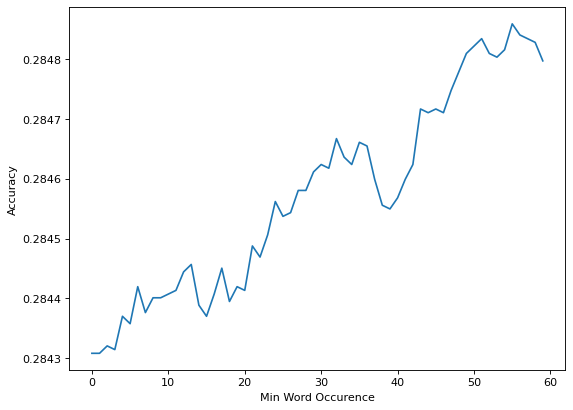

In [62]:
figure(figsize=(8, 6), dpi=80)
plt.plot(train_acc)
plt.xlabel("Min Word Occurence")
plt.ylabel("Accuracy")

In [63]:
train_acc.index(max(train_acc))

55

In [73]:
vector = TfidfVectorizer( min_df=9, stop_words='english')
word_vec = vector.fit_transform(train_text)

In [74]:
initial = ["random", "nndsvd", "nndsvda", "nndsvdar"]
train_score = [[],[],[],[]]
test_score = [[],[],[],[]]
beta = ['frobenius', 'kullback-leibler']
for i in range(len(initial)):
    for j in beta:
        if (j == 'kullback-leibler'):
            clf = NMF(init = initial[i] ,n_components=3, random_state=5 , beta_loss = j, solver = 'mu')
        else:
            clf = NMF(init = initial[i] ,n_components=3, random_state=5 , beta_loss = j)
        clf.fit(word_vec)
        w = clf.transform(word_vec)
        h = clf.components_

        tp=pd.DataFrame({'id':pd.DataFrame(w).idxmax(axis=1)})

        train_score[i].append(accuracy_score(tp['id'].to_numpy() , df_train['mod_rating']))

       

D:\Anaconda_Launcher\lib\site-packages\sklearn\decomposition\_nmf.py:226: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn("The multiplicative update ('mu') solver cannot update "


In [75]:
df = pd.DataFrame(columns = ["Frobenius" , "Kullback_leibler" ],
             index = ['random' , 'nndsvd' , 'nndsvda' , 'nndsvdar'])
df = df.T
df['random'] = [train_score[0][0], train_score[0][1]]
df['nndsvd'] = [train_score[1][0], train_score[1][1]]
df['nndsvda'] = [train_score[2][0], train_score[2][1]]
df['nndsvdar'] = [train_score[3][0], train_score[3][1]]


In [76]:
df

,random,nndsvd,nndsvda,nndsvdar
Frobenius,0.297805,0.267941,0.268071,0.267928
Kullback_leibler,0.345146,0.276521,0.303347,0.300328


**After identifying the optimal parameters for the NMF, let us now join both the training and test set to increase the library of the NMF for better accuracy.**

In [77]:
joint_df = pd.concat([df_train , df_test])
joint_df['review'] = joint_df['review'].astype(str)


In [82]:
vector = TfidfVectorizer( min_df = 55 , stop_words='english')
joint_word_vec = vector.fit_transform(joint_df.review)

clf = NMF(init = 'random' , n_components=3, random_state=2,solver = 'mu' , beta_loss = 'kullback-leibler')

clf.fit(joint_word_vec)
w = clf.transform(joint_word_vec)
h = clf.components_

tp=pd.DataFrame({'id':pd.DataFrame(w).idxmax(axis=1)})
## Number of categorizations

tp.value_counts()

accuracy_score(tp['id'].to_numpy() , joint_df['mod_rating'])

0.40917312601423766

## Modelling Summary / Discussion

We started off by dividing the train dataset into further train and test sets with the division set at 0.2 for test set. 

**NMF**:The first model that we trained was the Non-Zero Matrix Factorization of the complete train data. The reason we took the entire data was it is not effected by any kind of overfitting since the data will not be based on any initial set outcome. After training the data and testing it on the train data we got an **accuracy of a mere 28%**. We then tested it on the actual test data provided as well which also gave an accuracy of 28%. This tends us to believe that the nmf is not really a good choice here with the lack of accuracy it is showing in both the datasets. 

We later tried to optimize the NMF by optimizing the minimum acceptable word occurence whcih came out to be at '55'.  We also went over the various init types and loss function to identify the best parameters. From these, we found that the best **init was set at 'random'** with the **loss function at 'kullback leibler'**. **Once we set these new parameters and joined both the train the test set for enhanced accuracy, we got an accuracy of 41%** which is mark difference from our initial model but still is not accuracte enough.


**Random Forest**: The Random forest model seemed to give the best result with an **accuracy of 80% on the train set** and **79% on the test set**. These accuracies are quite near which indicates that the model is substantially good fit without any overfitting taking place.

**Naive bayes:** The naive Bayes model seems to fall in between the Random Forest and NF in terms of performance with a **constant accuracy of 60% on both the train and test set**.


# Results and Analysis

In [84]:
df_comp = pd.DataFrame(columns = ["Training Set" , "test Set" ],
             index = ['Random Forest' , 'Naive Bayes' , 'NMF'])
df_comp = df_comp.T
df_comp['Random Forest'] = [80 , 79]
df_comp['Naive Bayes'] = [59.6 , 59.6]
df_comp['NMF'] = [28 , 41]

<AxesSubplot:>

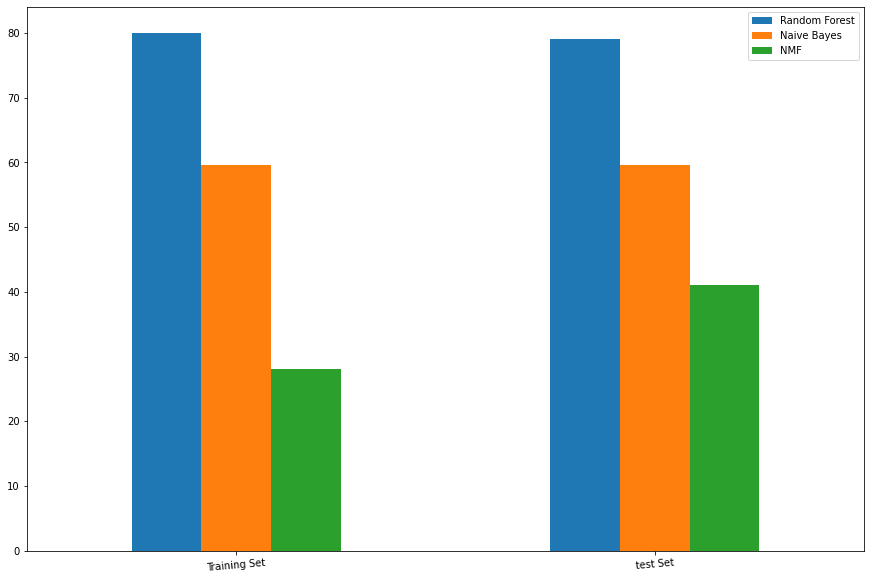

In [86]:
df_comp.plot(kind = 'bar', rot=5, fontsize=10, figsize=(15,10))

The final selected model is Random Forest which seems to be performing the best in both the training data and the test data. The accuracy for each data is as follows:

**Train Data : 80 %**

**Test Data : 79%**

Lets try to optimize the Random Forest further,

In [89]:
max_feat = [ 'auto', 'sqrt' , 'log2' ]

rf_scores = []

for i in max_feat:
    model = make_pipeline(TfidfVectorizer(stop_words='english'), RandomForestClassifier(max_features = i))

    model.fit(X_train , y_train)
    
    pred = model.predict(X_test)
    
    rf_scores.append(accuracy_score(y_test , pred))

In [90]:
rf_scores

[0.7953812771233726, 0.7964352138871668, 0.7830130192188469]

The default parameter setting of the Random Forest seems to be giving the best result and thus does not require any modification interms of the features. There is one thing to note however in the above graph that NMF showed quite an improvement when the parameters were fine tuned. This if in conjunction with further improvement in the text processing can probably be improved to produce much better results.

# Conclusion

In this project, multiple models were used to train the data both supervised and unsupervised learning methods. Both supervised learning models seemed to do better than the unsupervised learning method. However, it is important to note that the Matrix Factorization took a lot less time in model training and prediction as compared to the supervised learning method. The most important takeaway from this project was the need to properly clean the text. Many attempts were used to correctly identify the noise from the data to improve accuracy as well as time complexity. However, it is felt that the data still has a lot of room for improvement since many digits remained integrated with words which increased the time complexity and degraded the model overall accuracy.